Importing all the necessary libraries and setting up the Policy Network Class and DQN Class.
We have used libraries such as pytorch (for if we have a cuda capable GPU availbale), numpy, tqdm, and gym to set up our environment to learn to play 'LunarLander -v2'.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import gym
from tqdm import trange #gives us a neat little progress bar
from collections import namedtuple, deque
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Setting up the policy network
class QNet(nn.Module):
    def __init__(self, n_states, n_actions, n_hidden=64):
        super(QNet, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(n_states, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_actions)
            )

    def forward(self, x):
        return self.fc(x)

#Setting up the DQN class   
class DQN():
    def __init__(self, n_states, n_actions, batch_size=64, lr=0.0001, gamma=0.99, mem_size=int(1e5), learn_step=5, tau=0.001):
        self.n_states = n_states
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.gamma = gamma
        self.learn_step = learn_step
        self.tau = tau

        #Model
        self.net_eval = QNet(n_states, n_actions).to(device)
        self.net_target = QNet(n_states, n_actions).to(device)
        self.optimizer = optim.Adam(self.net_eval.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

        #MemoryManagenemt
        self.memory = ReplayBuffer(n_actions, mem_size, batch_size)
        self.counter = 0    #this updated the cycle count

    def getAction(self, state, epsilon):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)

        self.net_eval.eval()
        with torch.no_grad():
            action_values = self.net_eval(state)
        self.net_eval.train()

        #Setting up the epsilon-greedy algorithm
        if random.random() < epsilon:
            action = random.choice(np.arange(self.n_actions))
        else:
            action = np.argmax(action_values.cpu().data.numpy())

        return action

    def save2memory(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

        self.counter += 1
        if self.counter % self.learn_step == 0:
            if len(self.memory) >= self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences)

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        q_target = self.net_target(next_states).detach().max(axis=1)[0].unsqueeze(1)
        y_j = rewards + self.gamma * q_target * (1 - dones)          #This is the target
        q_eval = self.net_eval(states).gather(1, actions)

        #Backpropogating the loss
        loss = self.criterion(q_eval, y_j)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        #Soft Updation to the target network
        self.softUpdate()

    def softUpdate(self):
        for eval_param, target_param in zip(self.net_eval.parameters(), self.net_target.parameters()):
            target_param.data.copy_(self.tau*eval_param.data + (1.0-self.tau)*target_param.data)


class ReplayBuffer():
    def __init__(self, n_actions, memory_size, batch_size):
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.memory = deque(maxlen = memory_size)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def __len__(self):
        return len(self.memory)

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

Setting up the training and testing algorithms in the next phase.

In [2]:

#Training algorithm
def train(env, agent, n_episodes=1000, max_steps=1000, eps_start=1.0, eps_end=0.1, eps_decay=0.995, target=180, chkpt=False):
    score_hist = []
    epsilon = eps_start

    bar_format = '{l_bar}{bar:10}| {n:4}/{total_fmt} [{elapsed:>7}<{remaining:>7}, {rate_fmt}{postfix}]'
    pbar = trange(n_episodes, unit="ep", bar_format=bar_format, ascii=True)
    for idx_epi in pbar:
        state = env.reset()
        score = 0
        for idx_step in range(max_steps):
            action = agent.getAction(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            agent.save2memory(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break

        score_hist.append(score)
        score_avg = np.mean(score_hist[-100:])
        epsilon = max(eps_end, epsilon*eps_decay)

        pbar.set_postfix_str(f"Score for the episode: {score: 7.2f}, Average score over the last 100 episodes: {score_avg: 7.2f}")
        pbar.update(0)

        #Trying to break the training if a target reward is reached.
        if len(score_hist) >= 100:
            if score_avg >= target:
                break

    if (idx_epi+1) < n_episodes:
        print("\nThe target reward has been reached. Training exiting.")
    else:
        print("\nTotal training episodes complete!")
        
    if chkpt:
        torch.save(agent.net_eval.state_dict(), 'checkpoint.pth')

    return score_hist

#Testing algorithm
def testLander(env, agent, loop=3):
    test_hist = []
    global test_score
    for i in range(loop):
        state = env.reset()
        test_score = 0
        for idx_step in range(500):
            action = agent.getAction(state, epsilon=0)
            env.render()
            state, reward, done, _ = env.step(action)
            test_score +=reward
            if done:
                break
        test_hist.append(test_score)
    env.close()
    return test_hist

#plotting respective graphs    
def plotScore(scores):
    plt.figure()
    plt.plot(scores)
    plt.title("Training Score Growth History")
    plt.xlabel("Episodes")
    plt.show()

def plotTestScore(test_scores):
    plt.figure()
    plt.plot(test_scores)
    plt.title("Test Rewards History")
    plt.xlabel("Test Episodes")
    plt.show

Setting the parameters for our environment to begin training and testing.

In [3]:
BATCH_SIZE = 128
LR = 0.001
EPISODES = 1000
TARGET_SCORE = 185.     # early training stop target
GAMMA = 0.99            # discount factor
MEMORY_SIZE = 10000     # max memory buffer size
LEARN_STEP = 5          # how often to learn
TAU = 1e-3              # for soft update of target parameters
SAVE_CHKPT = True       # save trained network .pth file (saving it just for reference)

Initializing gym and training the network to land the probe the best way possible.

/Users/sunnydavid/Library/Python/3.9/lib/python/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/sunnydavid/Library/Python/3.9/lib/python/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
  0%|          |    0/1000 [  00:00<      ?, ?ep/s]2024-04-22 09:56:48.495 Python[86220:15438770] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
/Users/sunnydavid/Library/Python/3.9/lib/python/site-packages/gym/utils/pass


The target reward has been reached. Training exiting.


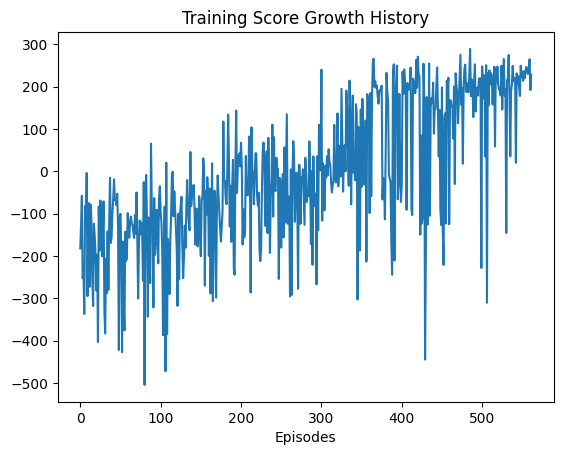

In [4]:
env = gym.make('LunarLander-v2', render_mode = 'human') #initializing the environment
num_states = env.observation_space.shape[0]
num_actions = env.action_space.n
agent = DQN(
    n_states = num_states,
    n_actions = num_actions,
    batch_size = BATCH_SIZE,
    lr = LR,
    gamma = GAMMA,
    mem_size = MEMORY_SIZE,
    learn_step = LEARN_STEP,
    tau = TAU,
    )
score_hist = train(env, agent, n_episodes=EPISODES, target=TARGET_SCORE, chkpt=SAVE_CHKPT)
plotScore(score_hist)

if str(device) == "cuda":
    torch.cuda.empty_cache()

Above is the reward hisotry over a 1000 episodes. In this case the target average reward of 185 was reached at around 560 episodes and hence the program exited. We can change this so that it does all 1000 episodes, but after a certain point, it is diminishing returns. (Also, it was generally just taking too long to train hence I added this exiting strategy.)

Next we used the trained network to test using the testLander method and then plot the output of the rewards over a 100 testing episodes.

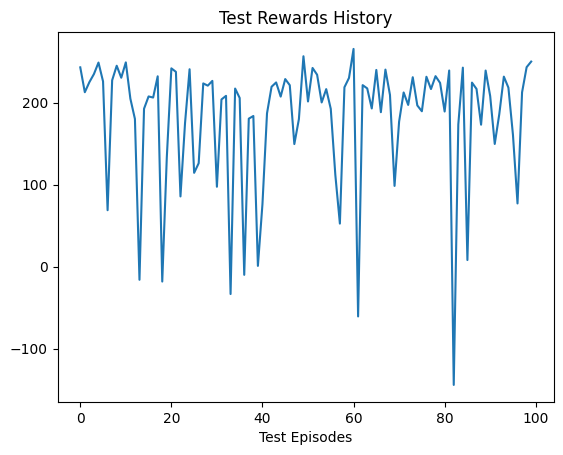

: 

In [5]:
#The testLander method returns a list of rewards to plotTestScore that then plots the graph for the testing phase. 
plotTestScore(testLander(env, agent, loop=100))
